In [62]:
import numpy as np
from sklearn.model_selection import train_test_split
import csv
import matplotlib.pyplot as plt
import sys

In [4]:
def load_data_shopping(directory):
    with open(directory) as f:
        reader = csv.DictReader(f)

        evidence = []
        labels = []

        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

        for row in reader:
            row_evidence = [
                int(row["Administrative"]),
                float(row["Administrative_Duration"]),
                int(row["Informational"]),
                float(row["Informational_Duration"]),
                int(row["ProductRelated"]),
                float(row["ProductRelated_Duration"]),
                float(row["BounceRates"]),
                float(row["ExitRates"]),
                float(row["PageValues"]),
                float(row["SpecialDay"]),
                months.index(row["Month"]),
                int(row["OperatingSystems"]),
                int(row["Browser"]),
                int(row["Region"]),
                int(row["TrafficType"]),
                1 if row["VisitorType"] == "Returning_Visitor" else 0,
                1 if row["Weekend"] == "TRUE" else 0
            ]

            label = 1 if row["Revenue"] == "TRUE" else 0

            evidence.append(row_evidence)
            labels.append(label)

        return (evidence, labels)

In [2]:
def initialize_params(layers: int, n_neurons: list):
    if len(n_neurons) != layers:
        return "Invalid number of neurons per layer."
    weights = []
    bias = []
    for i in range(layers - 1):
        W = np.random.randn(n_neurons[i + 1], n_neurons[i])
        b = np.random.randn(n_neurons[i + 1], 1)
        weights.append(W)
        bias.append(b)
    return (weights, bias)

In [5]:
def Sigmoid(z):
    return 1 / (1 + np.exp(-z))

def Sigmoid_derivative(z):
    s = Sigmoid(z)
    return s * (1 - s)

def ReLU(z):
    return np.maximum(0, z)

def ReLU_derivative(z):
    return (z > 0).astype(float)

def Softmax(z):
    max_z = np.max(z, axis=1, keepdims=True)
    ez = np.exp(z - max_z)
    
    sum_ez = np.sum(ez, axis=1, keepdims=True)
    return ez / sum_ez

In [6]:
def forward(X, weights, bias, functions):
    if len(functions) != len(weights):
        return "Invalid number of functions."
    A = []
    Z = []
    a = X
    for i in range(len(weights)):
        z = a.dot(weights[i].T) + bias[i].T
        #z = weights[i] @ X + bias[i]
        Z.append(z)
        f = functions[i]
        if f == "ReLU":
            a = ReLU(z)
        elif f == "Sigmoid":
            a = Sigmoid(z)
        elif f == "Softmax":
            a = Softmax(z)
        else:
            return "Specify activation function."
        A.append(a)
    return A, Z

In [7]:
""" def backward(A, W, X, Z, y,  functions):
    n_layers = len(W) + 1
    gradients_w = []
    gradients_b = []
    
    # Start from output layer and move backwards
    for i in reversed(range(n_layers - 1)):
        if i == n_layers - 2:  # Output layer with softmax and cross-entropy loss
            dz = A[i] - y
        else:  # Hidden layers
            if functions[i] == "ReLU":
                dadz = ReLU_derivative(Z[i])
            elif functions[i] == "Sigmoid":
                dadz = Sigmoid_derivative(Z[i])
            else:
                return "Invalid activation function"
            
            dz = dz.dot(W[i + 1]) * dadz
        
        # Calculate gradients
        if i == 0:
            a_prev = X
        else:
            a_prev = A[i-1]
            
        dw = a_prev.T.dot(dz) / len(y)
        db = np.mean(dz, axis=0, keepdims=True)
        
        gradients_w.insert(0, dw)
        gradients_b.insert(0, db)
    
    return gradients_w, gradients_b """

def backward(A, W, X, Z, y, functions):
    m = y.shape[0]
    gradients_w = [0] * len(W)
    gradients_b = [0] * len(W)

    dz = A[-1] - y
    for i in reversed(range(len(W))):
        a_prev = X if i == 0 else A[i-1]
        gradients_w[i] = (dz.T @ a_prev) / m
        gradients_b[i] = np.mean(dz, axis=0, keepdims=True).T
        
        if i > 0:
            if functions[i-1] == "ReLU":
                dz = (dz @ W[i]) * ReLU_derivative(Z[i-1])
            elif functions[i-1] == "Sigmoid":
                dz = (dz @ W[i]) * Sigmoid_derivative(Z[i-1])
            else:
                raise ValueError("Función de activación inválida")
                
    return gradients_w, gradients_b


In [ ]:
""" def update_params(W, b, grads_w, grads_b, alpha):
    for i in range(len(W)):
        W[i] = W[i] - alpha*grads_w[i].T
        b[i] = b[i] - alpha*grads_b[i].T
    return W, b """

def update_params(W, b, grads_w, grads_b, alpha):
    for i in range(len(W)):
        W[i] = W[i] - alpha*grads_w[i]
        b[i] = b[i] - alpha*grads_b[i]
    return W, b

def get_predictions(a):
    return np.argmax(a, axis=1)

def get_accuracy(predictions, y):
    return np.mean(predictions == y)

def standardize(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

def create_mini_batches(X, y, batch_size):
    m = X.shape[0]
    # Barajar índices
    permutation = np.random.permutation(m)
    X_shuffled = X[permutation]
    y_shuffled = y[permutation]
    
    mini_batches = []
    num_batches = m // batch_size
    
    for i in range(num_batches):
        X_batch = X_shuffled[i*batch_size:(i+1)*batch_size]
        y_batch = y_shuffled[i*batch_size:(i+1)*batch_size]
        mini_batches.append((X_batch, y_batch))
    
    # Resto (si m % batch_size != 0)
    if m % batch_size != 0:
        X_batch = X_shuffled[num_batches*batch_size:]
        y_batch = y_shuffled[num_batches*batch_size:]
        mini_batches.append((X_batch, y_batch))
    
    return mini_batches

def mini_batch(X, y, size):
    random_indexes = np.random.choice(X.shape[0], size=size, replace=False)
    return (X[random_indexes, :], y[random_indexes])

In [75]:
evidence, labels = load_data_shopping("shopping.csv")
X_train, X_test, y_train, y_test = train_test_split(
    evidence, labels, test_size=0.3
)

X_test = np.array(X_test)
Y_test = y_test
Y = np.array(y_train)
y = np.eye(2)[y_train]
X = standardize(np.array(X_train))

""" X = np.array([
    [0.5, 1.2, 0.8],
    [1.5, 0.3, 1.0],
    [0.4, 1.5, 0.7]
])
Y = np.array([0, 1, 0])
y = np.eye(2)[Y] """

#define network
ITERATIONS = 500
alpha = 0.01
epochs = ITERATIONS
layers = 4
batch_size = 10
n_neurons = [len(X[0]), 20, 10, 2]
functions = ["ReLU", "Sigmoid", "Softmax"]

weights, bias = initialize_params(layers, n_neurons)

""" while epochs > 0:
    A, Z = forward(X, weights, bias, functions)
    gradients_w, gradients_b = backward(A, weights, X, Z, y, functions)
    weights, bias = update_params(weights, bias, gradients_w, gradients_b, alpha)
    if epochs % 50 == 0:
        print("Epoch: ", ITERATIONS - epochs)
        print("Train Accuracy: ", get_accuracy(get_predictions(A[-1]), Y))
        A_test = forward(X_test, weights, bias, functions)[0]
        print("Test Accuracy: ", get_accuracy(get_predictions(A_test[-1]), Y_test))
    epochs -= 1
print("Epoch: ", ITERATIONS - epochs)
print("Train Accuracy: ", get_accuracy(get_predictions(A[-1]), Y))
A_test = forward(X_test, weights, bias, functions)[0]
print("Test Accuracy: ", get_accuracy(get_predictions(A_test[-1]), Y_test)) """

train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(ITERATIONS):
    mini_batches = create_mini_batches(X, Y, batch_size)
    for X_mb, Y_mb in mini_batches:
        y_mb = np.eye(2)[Y_mb]
        A, Z = forward(X_mb, weights, bias, functions)
        gradients_w, gradients_b = backward(A, weights, X_mb, Z, y_mb, functions)
        weights, bias = update_params(weights, bias, gradients_w, gradients_b, alpha)
    if epoch % 10 == 0:
        print("Epoch: ", epoch)
        epoch_list.append(epoch)
        A_acc, Z_acc = forward(X, weights, bias, functions)
        train_acc = get_accuracy(get_predictions(A_acc[-1]), Y)
        train_acc_list.append(train_acc)
        print("Train Accuracy: ", train_acc)
        A_test = forward(X_test, weights, bias, functions)[0]
        test_acc = get_accuracy(get_predictions(A_test[-1]), Y_test)
        test_acc_list.append(test_acc)
        print("Test Accuracy: ", test_acc)

Epoch:  0
Train Accuracy:  0.8389526126752405
Test Accuracy:  0.8072452014057854


C:\Users\PcCom\AppData\Local\Temp\ipykernel_9452\2854824060.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch:  10
Train Accuracy:  0.8821689259645464
Test Accuracy:  0.8413084617464179
Epoch:  20
Train Accuracy:  0.889352334607809
Test Accuracy:  0.8413084617464179
Epoch:  30
Train Accuracy:  0.8921330089213301
Test Accuracy:  0.8413084617464179
Epoch:  40
Train Accuracy:  0.8923647317807901
Test Accuracy:  0.8415788050824548
Epoch:  50
Train Accuracy:  0.8953771289537713
Test Accuracy:  0.8415788050824548
Epoch:  60
Train Accuracy:  0.8980419418375623
Test Accuracy:  0.8394160583941606
Epoch:  70
Train Accuracy:  0.8994322789943228
Test Accuracy:  0.8380643417139767
Epoch:  80
Train Accuracy:  0.9016336461591936
Test Accuracy:  0.8380643417139767
Epoch:  90
Train Accuracy:  0.9046460433321747
Test Accuracy:  0.8386050283860503
Epoch:  100
Train Accuracy:  0.9049936276213648
Test Accuracy:  0.8375236550419032
Epoch:  110
Train Accuracy:  0.9041825976132546
Test Accuracy:  0.8364422816977561
Epoch:  120
Train Accuracy:  0.9046460433321747
Test Accuracy:  0.8350905650175723
Epoch:  130
Tr

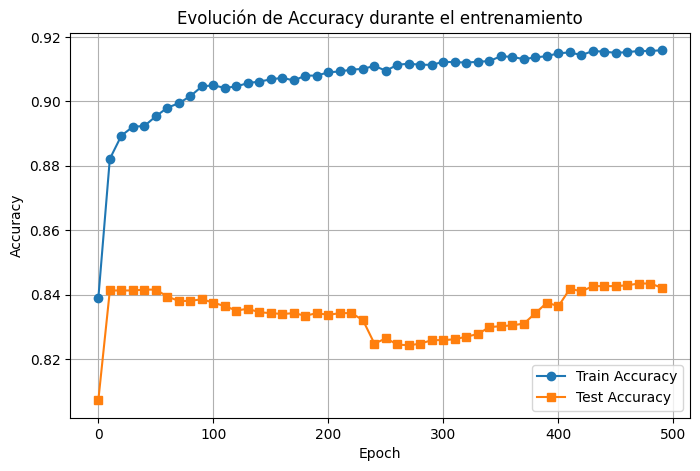

In [76]:
plt.figure(figsize=(8,5))
plt.plot(epoch_list, train_acc_list, label="Train Accuracy", marker='o')
plt.plot(epoch_list, test_acc_list, label="Test Accuracy", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evolución de Accuracy durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
weights, bias = initialize_params(4, [17, 10, 10, 2])
A, Z = forward(X, weights, bias, ["ReLU", "ReLU", "Softmax"])

g_w, g_b = backward(A, weights, X, Z, y, ["ReLU", "ReLU", "Softmax"])
weights, bias = update_params(weights, bias, g_w, g_b, alpha)

A, Z = forward(X, weights, bias, ["ReLU", "ReLU", "Softmax"])
A_test = forward(X_test, weights, bias, ["ReLU", "ReLU", "Softmax"])[0]

print(A)
#get_accuracy(get_predictions(A_test), Y_test)

In [69]:
len(epoch_list)

50